### Random Walk while inserting the coordinates/movement direction to the CNN and RNN
Here I will try to insert the direction of the path taken to the networks. 
<br> So... if our Syclop move in the following trajectory: [x,y]
<br> [36, 36],
<br>        [33, 37],
<br>        [34, 39],
<br>[35, 39],
<br>       [36, 40])
<br> I will concatinate the [x,y] values to the network state after the CNN network and before the RNN or FC networks. 
<br> We can also insert the destination and the source - [x_t,y_t],[x_t-1, y_t-1]


In [1]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net
import pickle

In [2]:
import importlib
importlib.reload(misc)

<module 'misc' from '/home/bnapp/arivkindNet/or_branch/imagewalker/misc.py'>

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

In [4]:

from __future__ import division, print_function, absolute_import

# # PyTorch libraries and modules
# import torchvision
import torch
# import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable
# from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
# from torch.optim import Adam, SGD
# import torch.nn as nn
from mnist import MNIST

mnist = MNIST('/home/bnapp/datasets/mnist/')
images, labels = mnist.load_training()

# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

import matplotlib.pyplot as plt
%matplotlib notebook
import SYCLOP_env as syc

#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    return upsmp

### Show an example of Syclop path and outputs:

In [5]:
img=misc.build_mnist_padded(1./256*np.reshape(images[45],[1,28,28]))

In [6]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [7]:
starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
steps  = []
for j in range(5):
    steps.append(starting_point*1)
    starting_point += np.random.randint(-5,5,2) 

q_sequence = np.array(steps).astype(int)
q_sequence

array([[36, 36],
       [31, 37],
       [31, 35],
       [32, 31],
       [29, 29]])

In [8]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(28,28))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(10):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


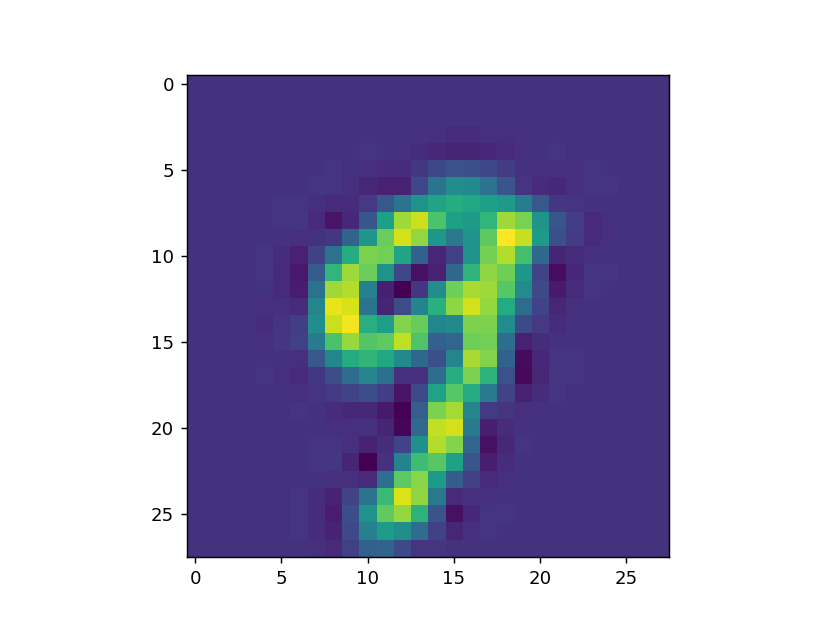

<IPython.core.display.Javascript object>


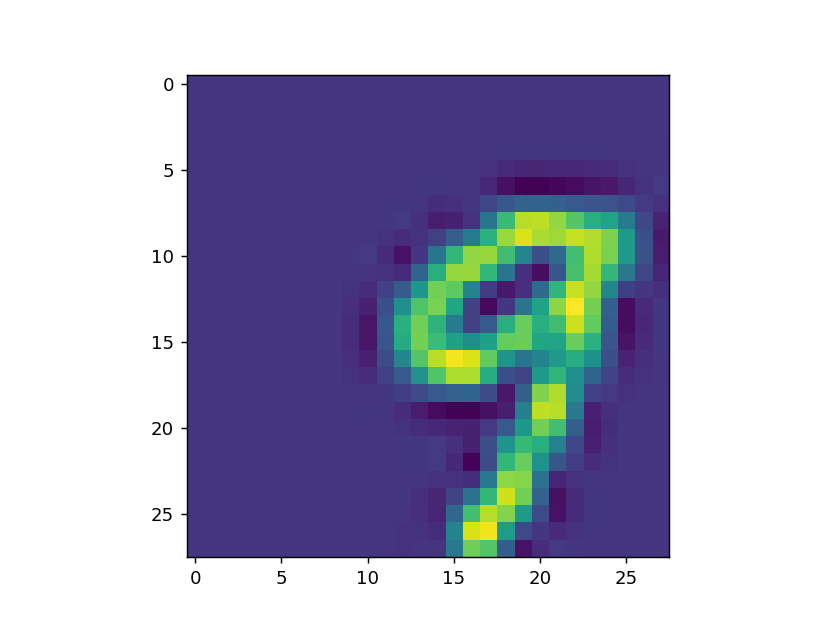

<IPython.core.display.Javascript object>


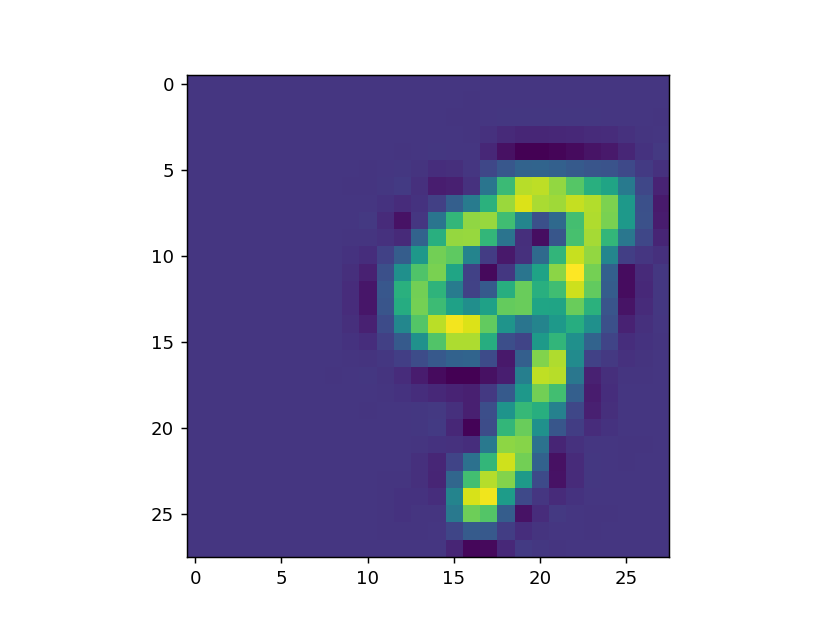

<IPython.core.display.Javascript object>


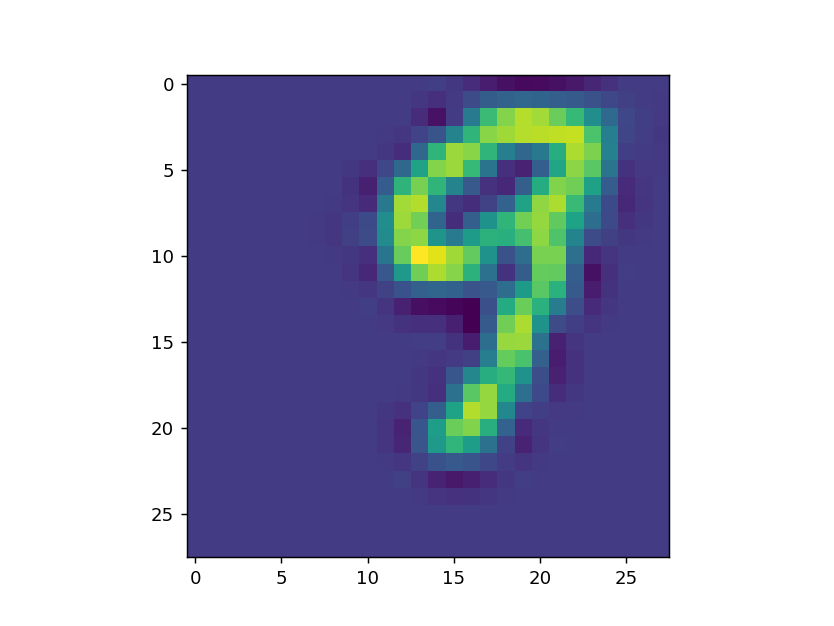

<IPython.core.display.Javascript object>


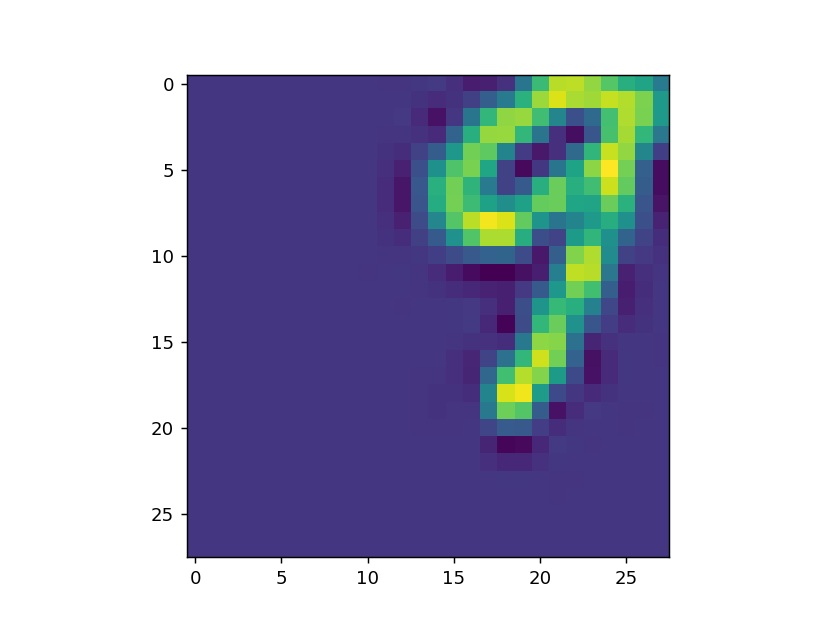

In [9]:
for i in range(5):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10) and make a circular movement in the x direction.
<br> 

In [10]:
def create_dataset(images, labels, res, sample = 5, mixed_state = True, add_traject = True,
                   trajectory_list=None,return_datasets=False):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.
    return_datasets: rerutns datasets rather than dataloaders
    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    q_seq = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img_num,img in enumerate(images):
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        if trajectory_list is None:
            starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
            steps  = []
            for j in range(5):
                steps.append(starting_point*1)
                starting_point += np.random.randint(-5,5,2) 

            if mixed_state:
                q_sequence = np.array(steps).astype(int)
            else:
                if count == 0:
                    q_sequence = np.array(steps).astype(int)
        else:
            q_sequence = np.array(trajectory_list[img_num]).astype(int)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[0]) 
            plt.title(labels[count])
            i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        q_seq.append(q_sequence)
        count += 1
        

    
    if add_traject: #If we add the trjectories the train list will become a list of lists, the images and the 
        #corrosponding trajectories, we will change the dataset structure as well. Note the the labels stay the same.
        ts_train = [ts_images[:55000], q_seq[:55000]] 
        train_labels = labels[:55000]
        ts_val = [ts_images[55000:], q_seq[55000:]]
        val_labels = labels[55000:]

    else:
        ts_train = ts_images[:55000]
        train_labels = labels[:55000]
        ts_val = ts_images[55000:]
        val_labels = labels[55000:]

    dvs_train = dvs_images[:55000]
    dvs_val = dvs_images[55000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, add_traject = False, transform = None):

            self.data = data
            self.labels = labels

            self.add_traject = add_traject
            self.transform = transform
        def __len__(self):
            if self.add_traject: 
                return len(self.data[0]) 
            else: return len(self.data[0])


        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            if self.add_traject:
                img_data = self.data[0][idx] 
                traject_data = self.data[1][idx]
                label = self.labels[idx]
                return img_data, traject_data, label
            else:
                data = self.data[idx]



            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels
        
    train_dataset = mnist_dataset(ts_train, train_labels,add_traject = True)
    test_dataset = mnist_dataset(ts_val, val_labels,add_traject = True)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    if return_datasets:
        return train_dataset, test_dataset
    else:
        return train_dataloader, test_dataloader, ts_train, train_labels


In [11]:
# with open('../../rlnet1/saved_runs/run_syclop_resolution101.py_noname__1619122748__10621//position_records.pkl','rb') as f:
with open('../../rlnet1/saved_runs/run_syclop_resolution101.py_noname__1619373185__66929//position_records.pkl','rb') as f:
    trajectory_list = pickle.load(f)


<IPython.core.display.Javascript object>


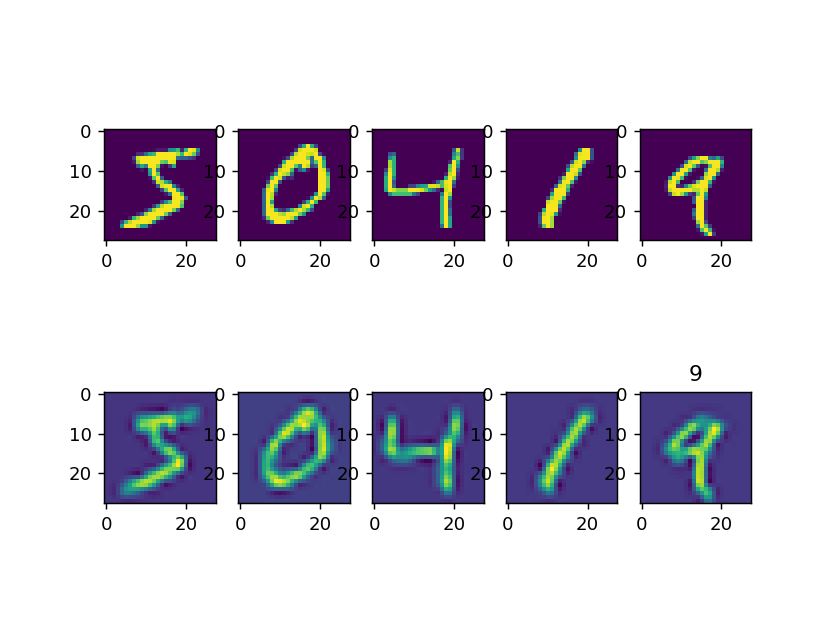

In [12]:
# train_dataloader, test_dataloader, ts_train, train_labels = create_dataset(images, labels,res = 28,trajectory_list=trajectory_list)


train_dataset, test_dataset = create_dataset(images, labels,res = 28,trajectory_list=trajectory_list,return_datasets=True)

In [13]:
n_timesteps = 5
inputA = keras.layers.Input(shape=(n_timesteps,28,28,1))
inputB = keras.layers.Input(shape=(n_timesteps,2))

# define CNN model
x1=keras.layers.TimeDistributed(keras.layers.Conv2D(16,(3,3),activation='relu'))(inputA)
x1=keras.layers.TimeDistributed(keras.layers.BatchNormalization())(x1)
x1=keras.layers.TimeDistributed(keras.layers.MaxPooling2D(pool_size=(2, 2)))(x1)

x1=keras.layers.TimeDistributed(keras.layers.Conv2D(32,(3,3),activation='relu'))(x1)
x1=keras.layers.TimeDistributed(keras.layers.BatchNormalization())(x1)
x1=keras.layers.TimeDistributed(keras.layers.MaxPooling2D(pool_size=(2, 2)))(x1)

x1=keras.layers.TimeDistributed(keras.layers.Conv2D(16,(3,3),activation='relu'))(x1)
print(x1.shape)

# x1=keras.layers.TimeDistributed(keras.layers.MaxPooling2D(pool_size=(2, 2)))(x1)
# print(x1.shape)

x1=keras.layers.TimeDistributed(keras.layers.Flatten())(x1)
print(x1.shape)

x = keras.layers.Concatenate()([x1,inputB])
print(x.shape)
# define LSTM model
x = keras.layers.GRU(100,input_shape=(n_timesteps, None),return_sequences=False)(x)
x = keras.layers.Dense(10,activation="softmax")(x)
model = keras.models.Model(inputs=[inputA,inputB],outputs=x)

(?, 5, 3, 3, 16)
(?, 5, 144)
(?, 5, 146)


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 28, 28, 1) 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 5, 26, 26, 16 160         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 26, 26, 16 64          time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 13, 13, 16 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distr

In [15]:
opt=tf.keras.optimizers.Adam(lr=1e-3)

In [16]:
model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [17]:
def split_dataset_xy(dataset):
    dataset_x1 = [uu[0] for uu in dataset]
    dataset_x2 = [uu[1] for uu in dataset]
    dataset_y = [uu[-1] for uu in dataset]
    return (np.array(dataset_x1)[...,np.newaxis],np.array(dataset_x2)[:,:n_timesteps,:]),np.array(dataset_y)
train_dataset_x, train_dataset_y = split_dataset_xy(train_dataset)
test_dataset_x, test_dataset_y = split_dataset_xy(test_dataset)

In [19]:
train_dataset_x[0].shape

(55000, 5, 28, 28, 1)

In [21]:
print("Fit model on training data")
history = model.fit(
    train_dataset_x,
    train_dataset_y,
    batch_size=64,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(test_dataset_x, test_dataset_y) #(validation_images, validation_labels)
)

Fit model on training data
Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 137s 2ms/step - loss: 0.1911 - sparse_categorical_accuracy: 0.9492 - val_loss: 0.0633 - val_sparse_categorical_accuracy: 0.9826
Epoch 2/100
55000/55000 [==============================] - 135s 2ms/step - loss: 0.0493 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.0468 - val_sparse_categorical_accuracy: 0.9868
Epoch 3/100
55000/55000 [==============================] - 136s 2ms/step - loss: 0.0371 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.0411 - val_sparse_categorical_accuracy: 0.9876
Epoch 4/100
55000/55000 [==============================] - 135s 2ms/step - loss: 0.0284 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0415 - val_sparse_categorical_accuracy: 0.9888
Epoch 5/100
 7872/55000 [===>..........................] - ETA: 1:54 - loss: 0.0249 - sparse_categorical_accuracy: 0.9915

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


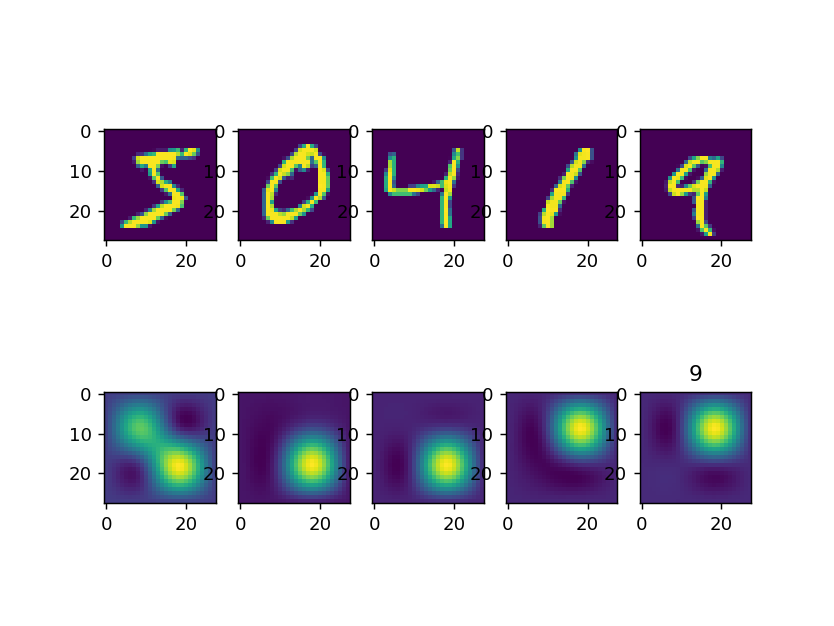

In [13]:
#Load the training data
train_dataloader, test_dataloader, _,_= create_dataset(images, labels,res = 6,trajectory_list=trajectory_list)